**Machine Learning Basic Principles 2018 - Data Analysis Project Report**
# Comparing ensembles in music genre classification

## Abstract

## 1. Introduction
The task is to classify songs into different musical genres ("pop rock", "electronic"...).

## 2. Data analysis
The data represents songs which have had their audio information preprocessed into 264 features, so our data has high dimensionality. They have 10 possible classes, or music genres. The training set has 4363 songs, and the test set has 6544 songs.

The class distribution is heavily imbalanced towards "Pop Rock".

In [58]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

# Read data
train_data_df = pd.read_csv("data/train_data.csv", header=None)
test_data_df = pd.read_csv("data/test_data.csv", header=None)
all_data_df = train_data_df.append(test_data_df)
train_labels_df = pd.read_csv("data/train_labels.csv", header=None, 
                              names=['class'])

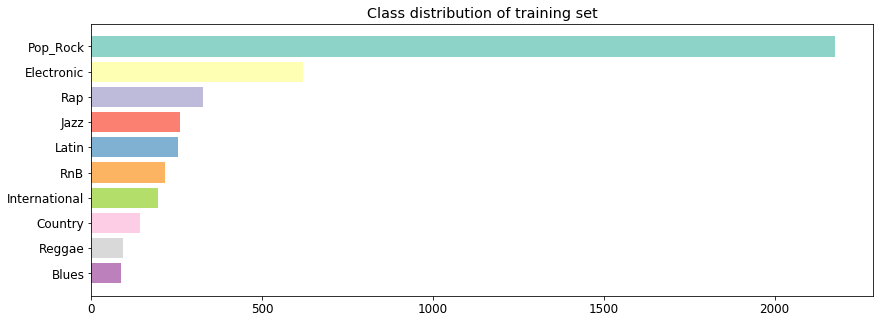

In [16]:
num_classes = 10
genres = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae', 'Blues']
class_counts = train_labels_df['class'].value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_classes)]
plt.barh(range(num_classes)[::-1], class_counts, tick_label=genres,
         color=colors)
plt.title('Class distribution of training set')
plt.show()

In [10]:
descriptive_stats = all_data_df.describe()

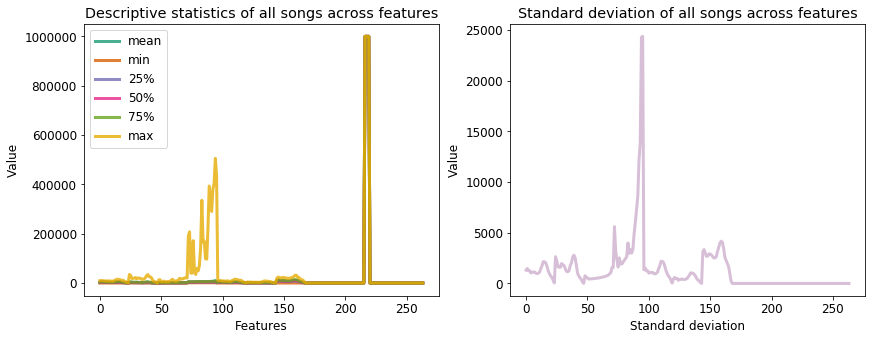

In [12]:
tab10_cmap = plt.cm.get_cmap(plt.cm.Dark2, 10)
value_stats = ['mean', 'min', '25%', '50%', '75%', 'max']
plt.subplot(1, 2, 1)
for i, stat in enumerate(value_stats):
    plt.plot(descriptive_stats.loc[stat], label=stat, lw=3, alpha=0.8, color=tab10_cmap(i))
plt.ylabel("Value")
plt.xlabel("Features")
plt.legend()
plt.title("Descriptive statistics of all songs across features")

plt.subplot(1, 2, 2)
plt.plot(descriptive_stats.loc['std'], label=stat, lw=3, color='thistle')
plt.ylabel("Value")
plt.xlabel("Standard deviation")
plt.title("Standard deviation of all songs across features")

plt.show()

**Features 216-219** have huge mean, min, max, and quartiles of exactly 1,000,000 for both train and test sets: this is because these features are uniformly 1,000,000 for all songs, meaning that they are **completely uninformative** and should be ignored by the training algorithm.

In [46]:
all_data_df.iloc[:, 216:220].T

,0,1,2,3,4,5,6,7,8,9,...,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543
216,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
217,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
218,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
219,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


Features 72-95, especially 72 and 88-95, also have very high max values compared to the 75th percentiles, which implies that **they have statistical outliers**. This is supported by the **unusually high variance** of features 72 and 88-95. These outliers will then impede dimensionality reduction via PCA, because the high variances will mislead PCA into heavily using these features as the primary eigenvectors.

From a visualization of the distributions of features, we can easily spot that some of the features are uniformly 1,000,000.

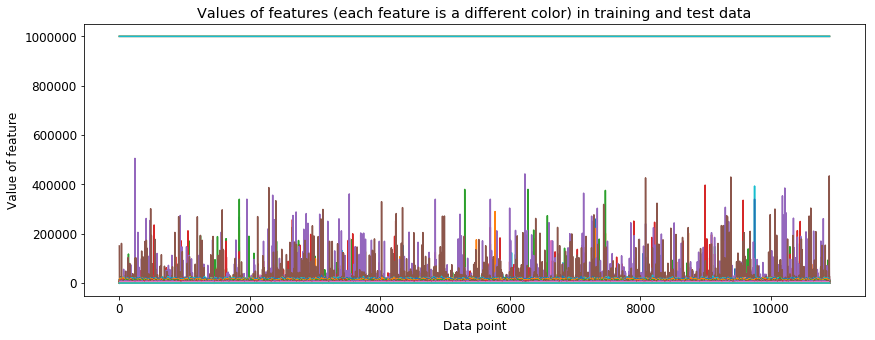

In [108]:
num_train_data, num_features = train_data_df.shape
indices = list(range(num_features))
for i in indices:
    plt.plot(all_data_df[i].values)
plt.xlabel("Data point")
plt.ylabel("Value of feature")
plt.title("Values of features (each feature is a different color) in training and test data")
plt.show()

After removing the useless features, the plot improves. However, there are still visibly huge differences in the ranges of different features. For some machine learning algorithms, this is undesirable.

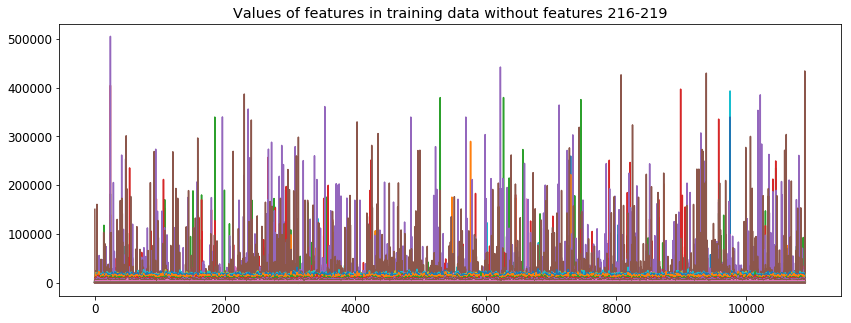

In [69]:
# Remove features 216-219 which have huge values
del indices[216:220]

for i in indices:
    plt.plot(all_data_df[i].values)
plt.title("Values of features in training data without features 216-219")
plt.show()

For each feature $x_i$ in each row of the input data, we rescale it such that its value is now between 0 and 1.
$$\dfrac{x_i – min(x)}{max(x) – min(x)}$$

This scaler works better for cases in which the standard scaler might not work so well. If the distribution is not Gaussian or the standard deviation is very small, the min-max scaler works better.



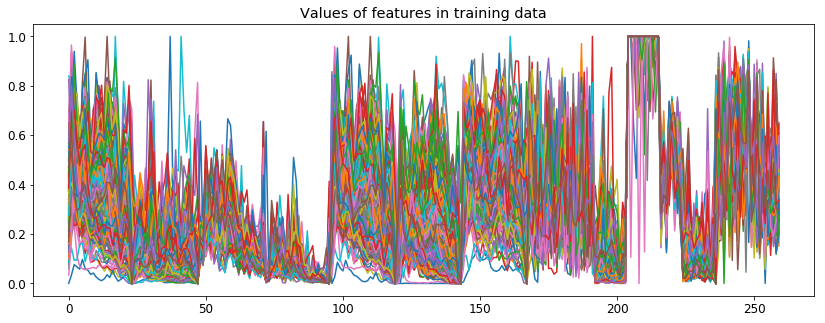

In [94]:
from sklearn import preprocessing
# Scale
std_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler()
min_max_scaler = preprocessing.MinMaxScaler()

scaled_data = min_max_scaler.fit_transform(train_data_df)
# scaled_data = std_scaler.fit_transform(train_data_df)
# scaled_data = robust_scaler.fit_transform(train_data_df)

del indices[216:220]

for i in indices:
    plt.plot(scaled_data[i])
plt.title("Values of features in training data")
plt.show()

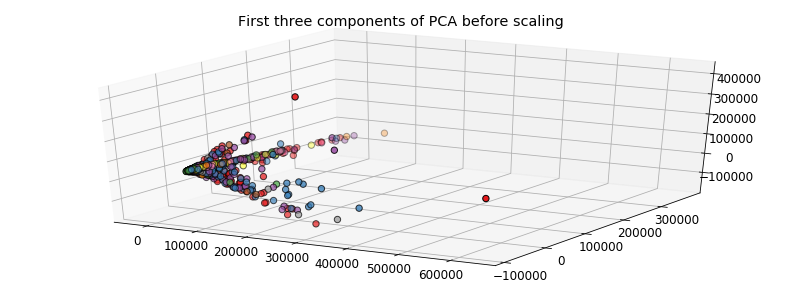

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(train_data_df)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA before scaling")

plt.show()

In [60]:
train_data_df = train_data_df.drop([216, 217, 218, 219], axis=1)
test_data_df = test_data_df.drop([216, 217, 218, 219], axis=1)

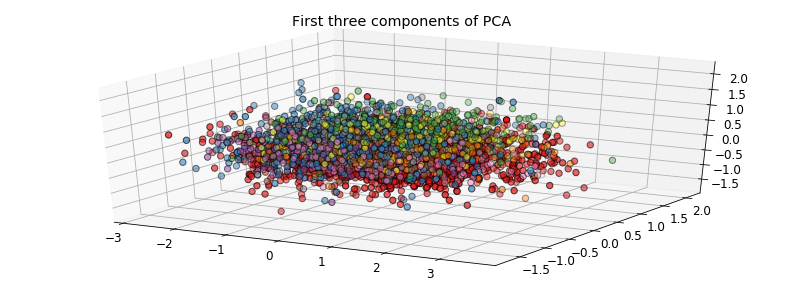

In [92]:
scaled_data = min_max_scaler.fit_transform(train_data_df)
# scaled_data = std_scaler.fit_transform(train_data_df)
# scaled_data = robust_scaler.fit_transform(train_data_df)

pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(scaled_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA")

plt.show()

Indeed, after min-max scaling the training data, the PCA visualization is much nicer.

# Methods and experiments

## Preprocessing
We use `MinMaxScaler` to scale all features, as mentioned in the previous section. A 70-30 split on the labeled training dataset is done and all the algorithms below are initially trained with the 70% training set and scored on both the training set and the 30% validation set. After tuning the hyperparameters with the validation set, the final models are then

## 1. Neural network


## 2. XGBoost

### How it works
Gradient Tree Boosting is a generalization of boosting to arbitrary differentiable loss functions. Accurate and effective.

XGBoost is a gradient boosting algorithm that accumulates weak learners and creates an ensemble. It is a popular library because it is has clever penalisation of Trees, A Proportional shrinking of leaf nodes Newton Boosting Extra Randomisation Parameter to reduce correlation between the trees

The advantages of GBRT are:

- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

- Scalability, due to the sequential nature of boosting it can hardly be parallelized.
### Motivation
Good performance in data science competitions.
### Experiments
We train 200 weak learners with early stopping.
Train with early stopping if there is no improvement in the logarithmic loss

## 3. SVC
a linear SVM creates a hyperplane that uses support vectors to maximise the distance between the two classes.. for multiclass setting, we train 10 one-vs-rest classifiers. However, one minor implementation detail is that we used sklearn's `LinearSVC` implementation which regularizes the bias, unlike a conventional SVC.

To transform the decision function outputs into a probability vector, we Platt’s sigmoid model [1], and then compute the validation log-loss based on that.

Because LinearSVC was so fast, we also did a parameter grid search.


## Voting Ensemble
We take the algorithms that are already conveniently inherits from Sklearn's BaseEstimator, and use them for various ensembling techniques

VotingClassifier, BaggingClassifier, AdaboostClassifier.


‘soft’ voting predicts the class label based on the argmax of the sums of the predicted probabilities.
Sequence of weights (float or int) to weight the class probabilities before averaging (soft voting). 



##  Evaluation

### Validation performance metrics
We **split the labeled training dataset into 30% validation set and keep the remaining 70% for training**. Then we use the validation logloss and accuracy as an "offline" proxy for its "online" performance on unseen data, i.e. on the private Kaggle test sets.

However, estimating the model's performance with a held-out validation set has a high variance due to differences in the training and validation sets.

### Cross-validation performance metrics
For the algorithms that are faster to train, we also use a *better (lower variance) but more computationally expensive* benchmark: **stratified k-fold cross validation**. We split the training set into $k$ folds, where the algorithm is run $k$ times on $k-1$ folds and tested on the held-back fold; each fold of the dataset is held back once. We use $k=3$, similar to how we did a 30-70 split when computing the traditional validation metrics.

Since our data has a class imbalance, we use **stratified folds** which enforce the same distribution of classes in each fold as in the whole training dataset.

This metric had a better correlation with the Kaggle performance. There were several cases where, the validation accuracy and log-loss looked promisingly good but the cross-validated scores were more realistic and indicative of its online performance. The inverse is also possible. For example, the ensemble of XGBoost and RandomForest performed well on Kaggle (0.65359) and also had high cross-validation scores (0.62737), but the performance metrics on the validation set were low: an accuracy of 0.51948.

![ensemble-xgb-rf cm](img/cm_ensemble_rf_xgb.png)

On Kaggle, a naive submission that classifies everything as "pop rock" gives an accuracy of 0.50993.

### AUC ROC
This is a proxy for how good the confusion matrix looks.
Either a `weighted` or `macro` averaging of the Area Under the Received Operating Characteristic Curve (ROC AUC) scores for each class on the validation set. Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. `weighted` Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

The `weighted` averaging of AUC scores will weight each class proportionately to the original class imbalance.

If we want to see how it would perform if all clases were uniform, we can look at the `macro` averaging which gives all classes the same weight.





*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *



*- What evaluation methodology (cross CV, etc.).*



In [100]:
from tensorflow.contrib.losses import tf_log_loss
from sklearn.metrics import accuracy_score, log_loss

eval_predicted_proba = model.predict_proba(eval_data)
onehot = to_categorical(eval_labels).astype(int) # Splits into classes from 0-10 (11 classes)
eval_onehot = onehot[:, 1:]  # Trim unnecessary first column (class "0")

log_loss(eval_onehot, eval_predicted_proba)
accuracy_score(eval_)

# Results

## Experimental outcomes
We compute AUC on the validation set
For `FINAL` models, there is no splitting between validation and test sets.

| Model                       | Log-loss [s.d.]     | Accuracy [s.d.]    | AUC (weighted/macro) | Kaggle (L-L) | Kaggle (Acc.) |
|----------------------------- |--------------------- |-------------------- |---------------------- |-------------- |---------------|
| XGBoost                     | 1.10483 [0.031224]* | 0.64055/0.01678    | 0.87161/0.86431      |      0.17474 |       0.64798 |
| XGBoost (S)                 | 1.11093 / 0.034256  | 0.63661/0.017100   | 0.87104/0.86205      |              |               |
| XGBoost (S, D)              | 1.12689 0.02131     | 0.63196 0.00806    | 0.87152/0.86687      |              |               |
| random forest               | 1.26570 0.00887     | 0.58742 0.00146    | 0.85220/ 0.84101     |              |               |
| random forest (S)           | 1.25397 0.01027     | 0.60622 0.00972    | 0.99831 /0.99956     |      0.19964 |       0.60163 |
| random forest (S, D)        | 1.25178 0.02163     | 0.59497 0.00607    | 0.85150/0.84345      |              |               |
| random forest (balanced)    | 1.36745 [0.02399]   | 0.59300 0.00134    | 0.84223/0.82973      |              |               |
| linearSVC                   | 1.21057 0.63713             | 0.59366 0.00369            | 0.84733/0.82310      |              |               |
| linearSVC (S)               | 1.13869[0.01445]*             | 0.64013[0.00716]*            | 0.86487/0.85752      |       0.19221       |     0.61487          |
| linearSVC (S, D)            |  1.13972[0.01345]            | 0.63817 0.00583            | 0.86474/0.85722      |              |               |
|final XGB | -1.09515[0.00780]* |  0.65460[0.00425]* | - | 0.17077 | 0.66225 |
|final RF | -1.35585[0.02808]* |  0.60577[0.00487]* | - | ? | ? |
|final SVC | -1.16738[0.01001]* |   0.64130[0.00309]* | - | ? | ? |
|----------------------------- |--------------------- |-------------------- |---------------------- |-------------- |---------------|
| ensemble (XGB, RF)          | 1.14183 [0.01128] * | 0.62737 [0.00150]* | 0.65397/0.62538      |      0.17287 |       0.65359 |
| ensemble (unfitted XGB, RF) | 1.16674 0.00728*    | 0.63523 0.00491*   | 0.87064/0.86256      |              |               |
| ensemble (final XGB, RF)          | 1.14325 0.00340 | 0.65482 0.00234 | - | ? | ? |
| ensemble (XGB, RF, SVC)          | -1.14984 0.00764 | 0.62344 0.00535 | 0.87358/0.86394 | 
| ensemble (final XGB, RF, SVC)          | 1.13104 0.00655 | 0.65505 0.00686 | - | 0.17544 | 0.66123|



* stratified K-fold cross-validation score



# Discussion
Scaling and dropping features does not improve XGBoost performance and even degrades it very slightly; this is likely because the algorithm has automatic feature selection; it learns to ignore outliers and uninformative features. 

Dropping the dummy variables (216-219) did not have an impact on any of the classifiers. As we can see from the feature importance graphs, all 3 algorithms successfully ignored the dummy variables perfectly.

However, scaling does slightly improve the performance of the random forest, although random forest is overall worse than XGBoost. Giving each class weights inversely proportional to class frequencies in the input data did not improve the performance metrics or the AUC score either.

Scaling also improves linearSVC by around 4.5% in accuracy and 0.0726 in log-loss. It is important to scale the input features before training a support vector machine, because SVM's will prioritize features of higher order of magnitude over lower magnitude features.

```
Since perfect collinearity can be a problem, the suggested approach is to set drop_first to True to get n-1 columns. You should use drop_first = True when you have a regression model, perfect collinearities are very problematic leading to unreliable and unstable estimates of regression coefficients, more than for classification problems.

Multi-collinearity will not be a problem for certain classification models. Such as RF , DTC, gradient boosting. Different tree model will have different deal method, such as the random forest will keep them both (because they build the trees independently, and perform random selection of features for every trees). So the model will still work well.

In our case (for variables with 3 or more categories) multicollineraties can be safely ignored. Dont use categorical conversion for 2 categories variables (Ex: Sex).

Yassine Ghouzam```

## Balancing the classes
Having a balanced random forest classifier degrades the log-loss slightly (0.01) as well as accuracy (1%). Using a balanced SVC degrades it far more with accuracy drops of around 10%, implying that SVC overfits to the class imbalance.

## Suggestions for future research/improvement.
We can use many methods to tune the hyperparameters of the XGBoost classifier, Random Forest classifier, and linear SVC. The naive way is exhaustive grid search, but we can also use randomized grid search, Bayesian optimization, evolutionary strategies, and more.


# References
[1] Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods, J. Platt, (1999)


# Appendix

## Instructions on 

## KNN